# LiDAR point cloud of the Trail Islands in British Columbia, Canada

This is a LiDAR point cloud from the [LidarBC](https://www2.gov.bc.ca/gov/content/data/geographic-data-services/lidarbc) project, sliced to the small [Trail Islands](https://apps.gov.bc.ca/pub/bcgnws/names/21973.html) North of Vancouver to reduce the data size. The islands have some nice looking topography and their isolated nature creates problems for some interpolation methods.

Coordinates of the original data are in NAD83 UTM zone 10 and the vertical datum for elevation is CGVD2013 (based on the Canadian geoid).

The horizontal datum was changed to WGS84 and coordinates un-projected to longitude, latitude.

License: [Open Government Licence - British Columbia](https://www2.gov.bc.ca/gov/content/data/open-data/open-government-licence-bc)

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pooch
import pyproj
import pygmt
import laspy 

## Download the tile we need

The islands are covered by the tile `bc_092g041` of the dataset. Download it with Pooch and cache it.

In [2]:
fname = pooch.retrieve(
    url="https://nrs.objectstore.gov.bc.ca/gdwuts/092/092g/2019/pointcloud/bc_092g041_4_2_2_xyes_8_utm10_2019.laz",
    known_hash="md5:5acad29ff5ba1f2a09453ed16c3004da",
)

In [3]:
print(f"size: {os.path.getsize(fname) / 1e6} Mb")

size: 83.871764 Mb


## Read the data

Use laspy to read in the data from the file. We'll read it in chunks and only take the ground reflectance points to avoid overloading our memory.

In [4]:
easts, norths, heights = [], [], []
with laspy.open(fname) as lasfile:
    for chunk in lasfile.chunk_iterator(100_000):
        ground = chunk.classification == 2
        easts.append(chunk.x.scaled_array()[ground].copy())
        norths.append(chunk.y.scaled_array()[ground].copy())
        heights.append(chunk.z.scaled_array()[ground].copy())
        
data_full = pd.DataFrame({
    "easting": np.concatenate(easts),
    "northing": np.concatenate(norths),
    "height": np.concatenate(heights),
})
data_full

,easting,northing,height
0,441500.56,5479185.08,-1.14
1,441500.54,5479184.50,-1.15
2,441500.43,5479183.88,-1.10
3,441500.84,5479184.13,-1.14
4,441501.26,5479184.38,-1.13
...,...,...,...
2489382,442012.88,5477949.65,-0.37
2489383,442012.58,5477949.15,-0.47
2489384,442014.16,5477950.85,-0.06
2489385,442013.24,5477949.33,-0.40


## Cut the data

Slice the data to just the islands to avoid having too large a dataset.

In [5]:
inside = vd.inside((data_full.easting, data_full.northing), region=(440600, 441600, 5478100, 5479000))
data = data_full[inside].reset_index(drop=True)
data

,easting,northing,height
0,441030.75,5478941.38,-0.67
1,441032.74,5478942.59,-0.96
2,441029.94,5478940.32,-0.78
3,441031.37,5478941.18,-0.61
4,441031.89,5478941.49,-0.62
...,...,...,...
829728,441484.31,5478352.06,-1.24
829729,441484.07,5478350.77,-1.25
829730,441483.66,5478349.07,-1.19
829731,441482.76,5478347.58,-1.21


## Plot the point cloud

Make a quick plot to make sure the data look OK.

Text(0, 0.5, 'UTM Northing (m)')

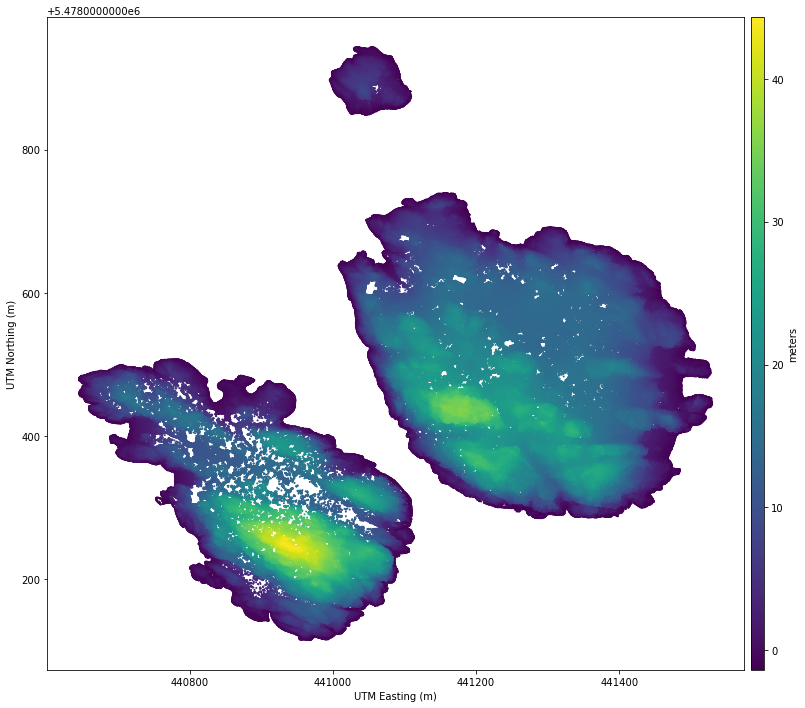

In [6]:
plt.figure(figsize=(15, 12))
plt.scatter(data.easting, data.northing, c=data.height, s=1)
plt.colorbar(label="meters", pad=0, aspect=50)
plt.axis("scaled")
plt.xlabel("UTM Easting (m)")
plt.ylabel("UTM Northing (m)")

## Convert UTM to latitude, longitude

Undo the projection and store the latitude, longitude so we don't need to preserve the UTM zone information.

In [7]:
wgs84 = pyproj.CRS.from_epsg(4326)
utm_nad83 = pyproj.CRS.from_proj4("+proj=utm +zone=10 +north +ellps=GRS80 +datum=NAD83 +units=m +no_defs")
transformer = pyproj.Transformer.from_crs(utm_nad83, wgs84, always_xy=True)

In [8]:
data["longitude"], data["latitude"] = transformer.transform(data.easting, data.northing)

Text(0, 0.5, 'Latitude')

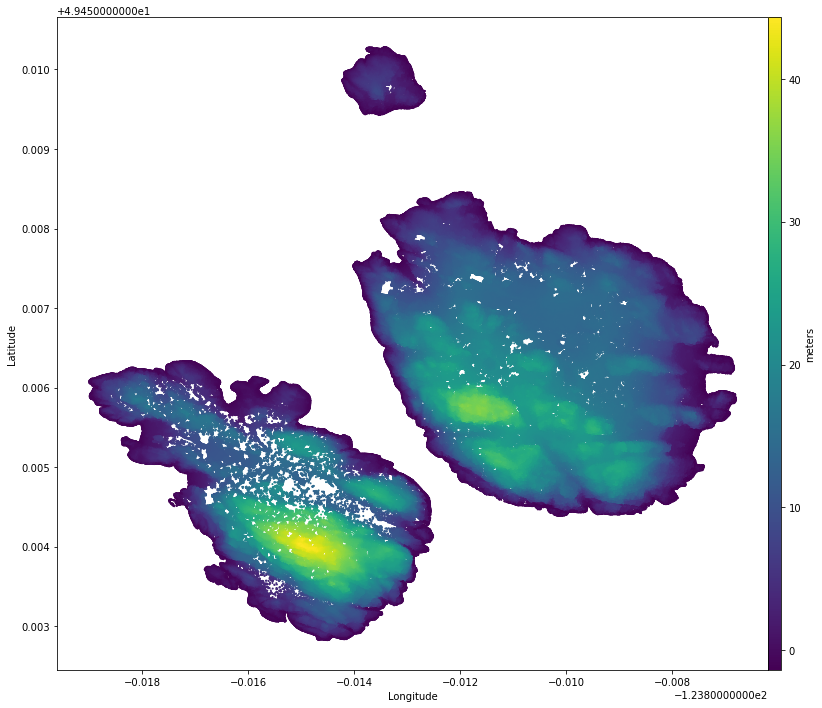

In [9]:
plt.figure(figsize=(15, 12))
plt.scatter(data.longitude, data.latitude, c=data.height, s=1)
plt.colorbar(label="meters", pad=0, aspect=50)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

## Export

Make a separate DataFrame to export to CSV with centimeter level precision.

In [10]:
export = pd.DataFrame({
    "longitude": data.longitude.map(lambda x: "{:.7f}".format(x)),
    "latitude": data.latitude.map(lambda x: "{:.7f}".format(x)),    
    "elevation_m": data.height.map(lambda x: "{:.2f}".format(x)),
})
export

,longitude,latitude,elevation_m
0,-123.8137526,49.4602634,-0.67
1,-123.8137253,49.4602745,-0.96
2,-123.8137636,49.4602538,-0.78
3,-123.8137440,49.4602617,-0.61
4,-123.8137369,49.4602645,-0.62
...,...,...,...
829728,-123.8074072,49.4550069,-1.24
829729,-123.8074104,49.4549953,-1.25
829730,-123.8074158,49.4549800,-1.19
829731,-123.8074280,49.4549665,-1.21


In [11]:
fname = "lidar-british-columbia.csv.xz"
export.to_csv(fname, index=False)
print(fname)
print(f"size: {os.path.getsize(fname) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(fname, alg=alg)}")

lidar-british-columbia.csv.xz
size: 4.378076 Mb
md5:354c725a95036bd8340bc14e043ece5a
sha256:03c6f1b99374b8c00c424c788cb6956bc00ab477244bb69835d4171312714fe1


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [12]:
lidar = pd.read_csv(fname)
lidar

,longitude,latitude,elevation_m
0,-123.813753,49.460263,-0.67
1,-123.813725,49.460274,-0.96
2,-123.813764,49.460254,-0.78
3,-123.813744,49.460262,-0.61
4,-123.813737,49.460265,-0.62
...,...,...,...
829728,-123.807407,49.455007,-1.24
829729,-123.807410,49.454995,-1.25
829730,-123.807416,49.454980,-1.19
829731,-123.807428,49.454966,-1.21


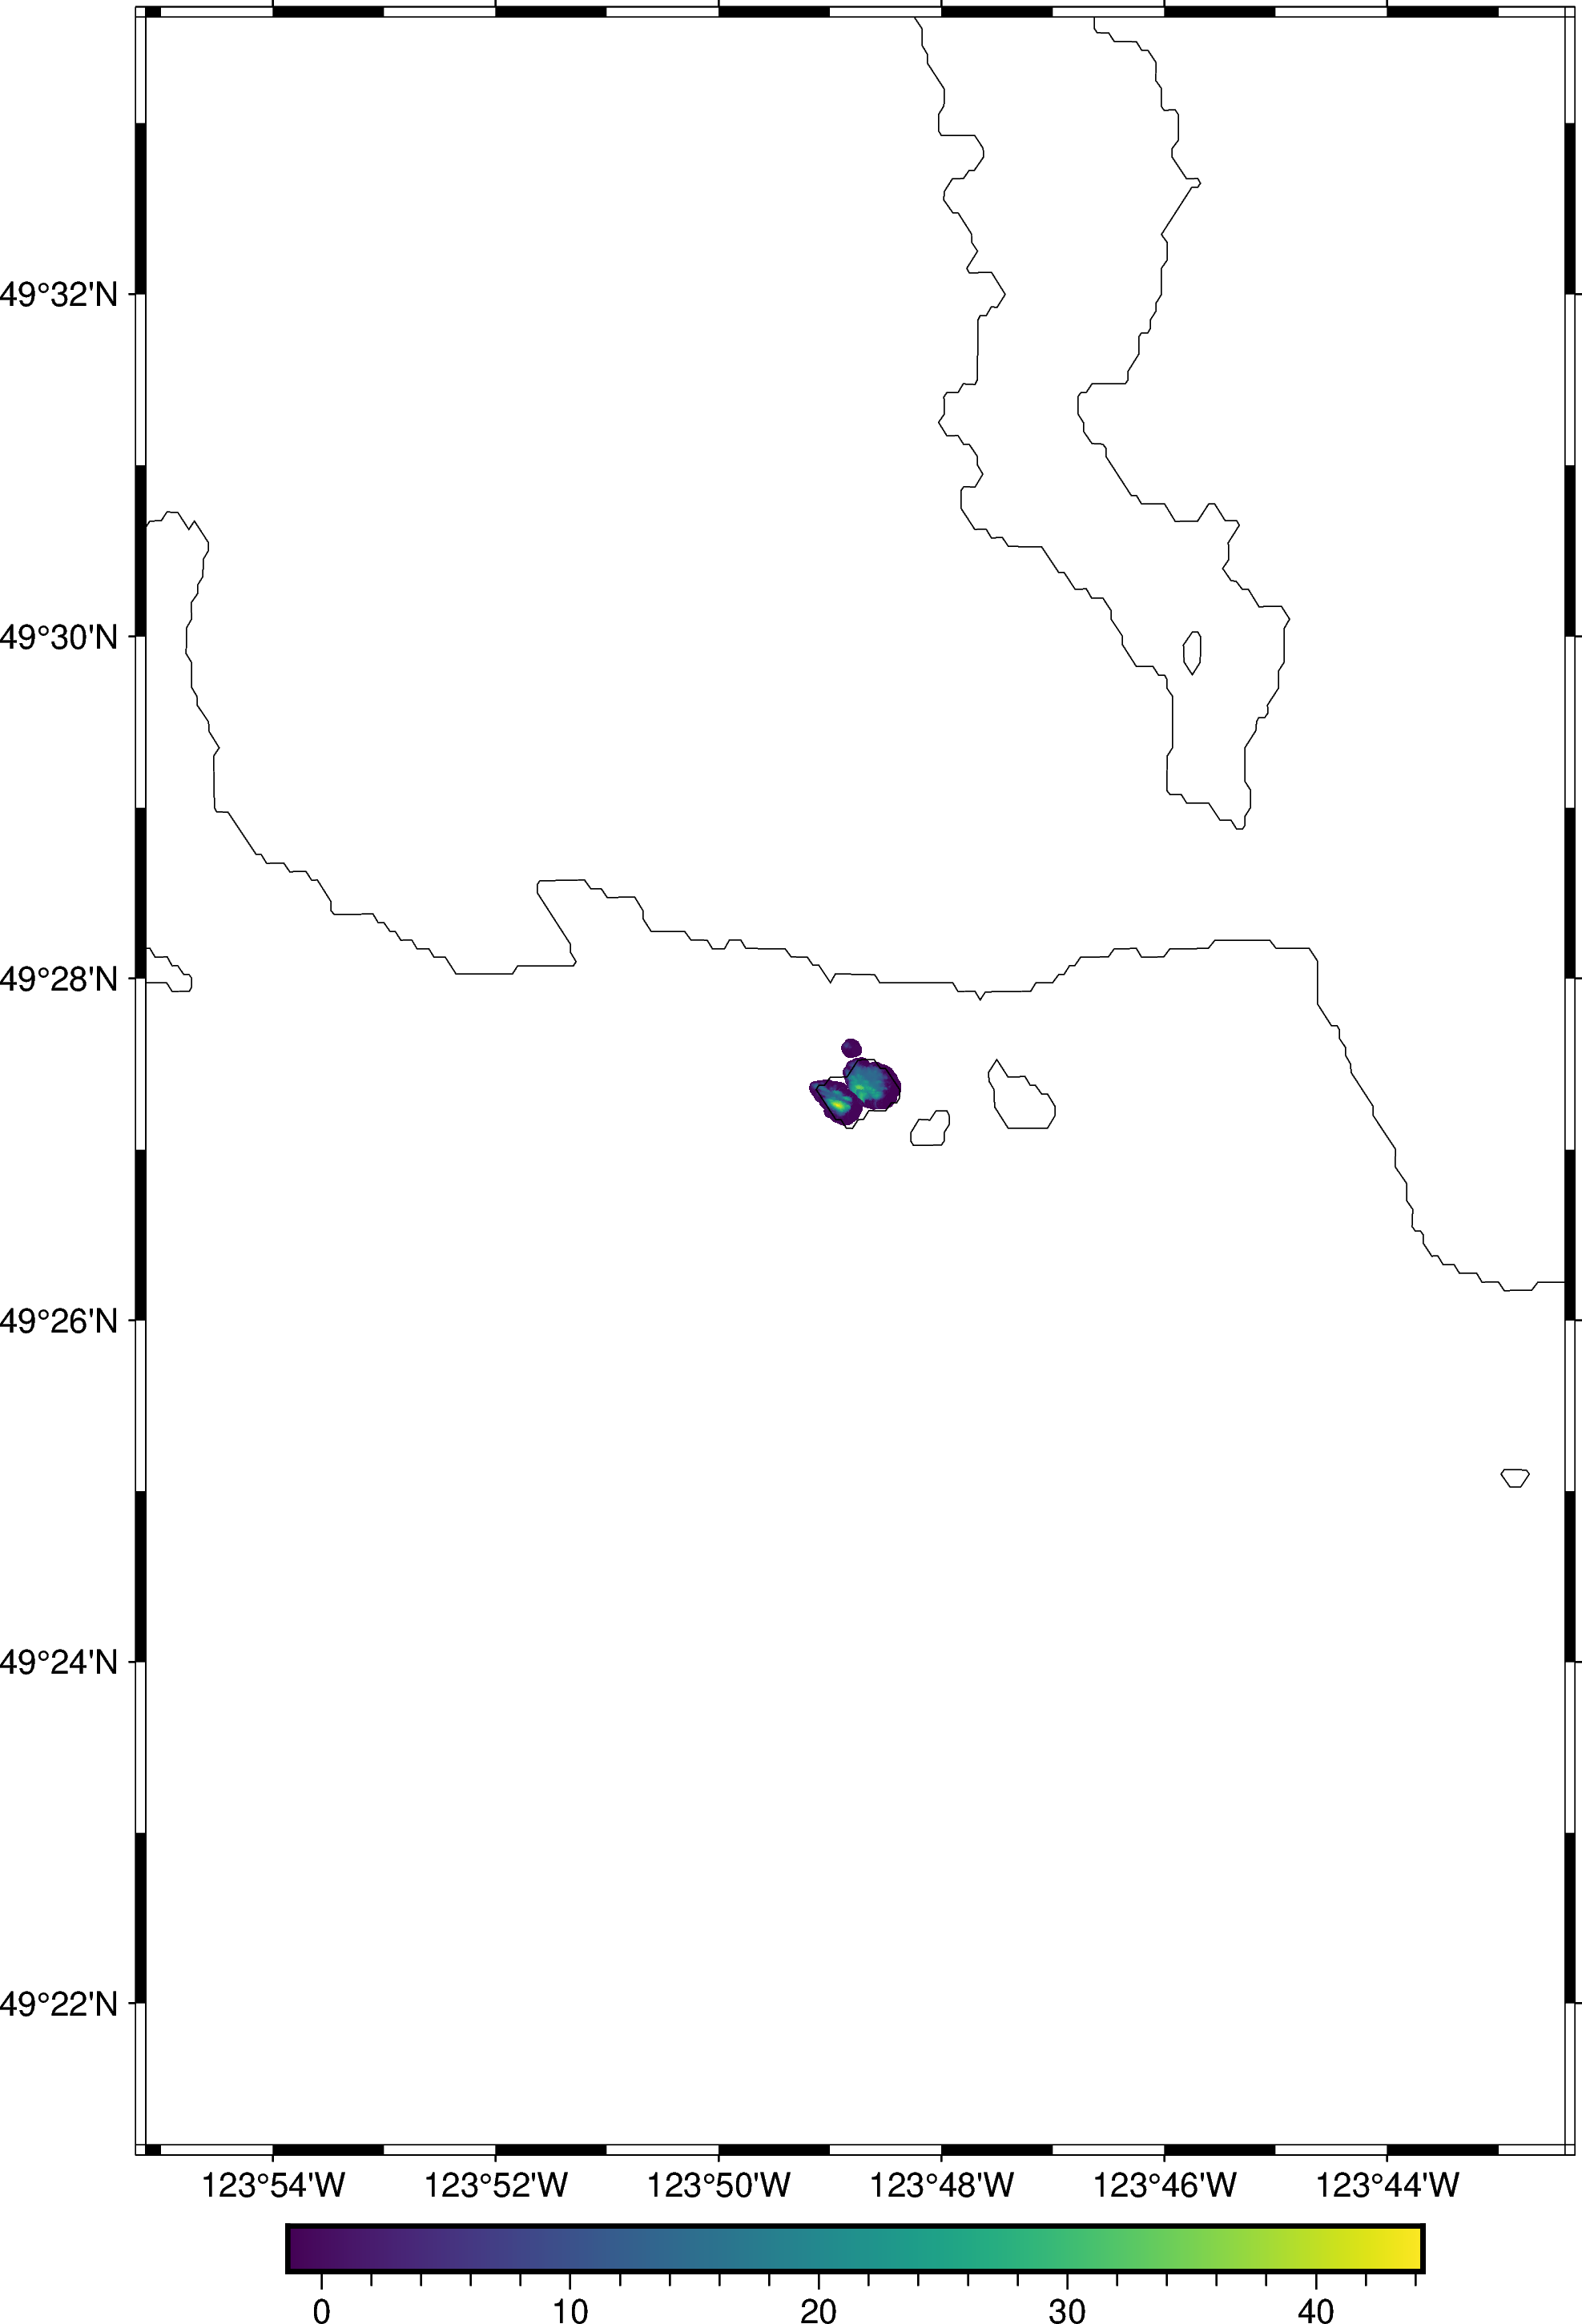

In [13]:
fig = pygmt.Figure()
fig.basemap(
    region=vd.pad_region(vd.get_region((lidar.longitude, lidar.latitude)), 0.1),
    projection="M15c",
    frame=True,
)
pygmt.makecpt(cmap="viridis", series=[lidar.elevation_m.min(), lidar.elevation_m.max()])
fig.plot(x=lidar.longitude, y=lidar.latitude, color=lidar.elevation_m, cmap=True, style="c0.1c")
fig.colorbar(frame="af")
fig.coast(shorelines=True, resolution="f")
fig.show()